In [38]:
import modulesForCalibration as mfc

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd

In [41]:
import numpy as np
from scipy.optimize import fmin

import cmath
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
from datetime import datetime
from tqdm import tqdm

In [43]:

from scipy.optimize import fmin_bfgs

In [44]:
df_price = pd.read_csv("spx_quotedata.csv", index_col=0)


In [ ]:
df_price.head(100)

In [46]:
df_price.columns

Index(['Calls', 'Last Sale', 'Net', 'Bid', 'Ask', 'Volume', 'IV', 'Delta',
       'Gamma', 'Open Interest', 'Strike', 'Puts', 'Last Sale.1', 'Net.1',
       'Bid.1', 'Ask.1', 'Volume.1', 'IV.1', 'Delta.1', 'Gamma.1',
       'Open Interest.1'],
      dtype='object')

In [47]:
callPrices = df_price[['Last Sale','Strike']]
# convert index to datetime
callPrices.index = pd.to_datetime(callPrices.index)

# Set the start date to compute the maturities? 
date_str = "2022-03-01"
# create a datetime object from the date string
start_date = datetime.strptime(date_str, "%Y-%m-%d")

# define a function to compute the difference in days between two dates
def date_diff(date):
    diff = (date - start_date)
    return diff.days

# create a new column in the DataFrame that contains the difference in days
callPrices['Maturity'] = callPrices.index.to_series().apply(date_diff)
callPrices['Maturity'] = callPrices['Maturity']/365
#callPrices['Strike'] = np.log(callPrices['Strike'].array)

In [48]:
callPrices

,Last Sale,Strike,Maturity
Expiration Date,,,
2023-03-31,14.62,4075.0,1.082192
2023-03-31,11.13,4080.0,1.082192
2023-03-31,8.03,4085.0,1.082192
2023-03-31,5.43,4090.0,1.082192
2023-03-31,3.50,4095.0,1.082192
...,...,...,...
2027-12-17,952.52,3900.0,5.800000
2027-12-17,863.71,4000.0,5.800000
2027-12-17,896.31,4100.0,5.800000


In [49]:
callPrices.describe()

,Last Sale,Strike,Maturity
count,306.000000,306.000000,306.000000
mean,181.710131,4085.016340,1.598926
std,192.508730,51.517144,0.908105
min,0.000000,3800.000000,1.082192
25%,50.945000,4075.000000,1.134247
50%,113.250000,4087.500000,1.235616
75%,263.015000,4100.000000,1.715068
max,979.690000,4300.000000,5.800000


In [50]:
from matplotlib import cm

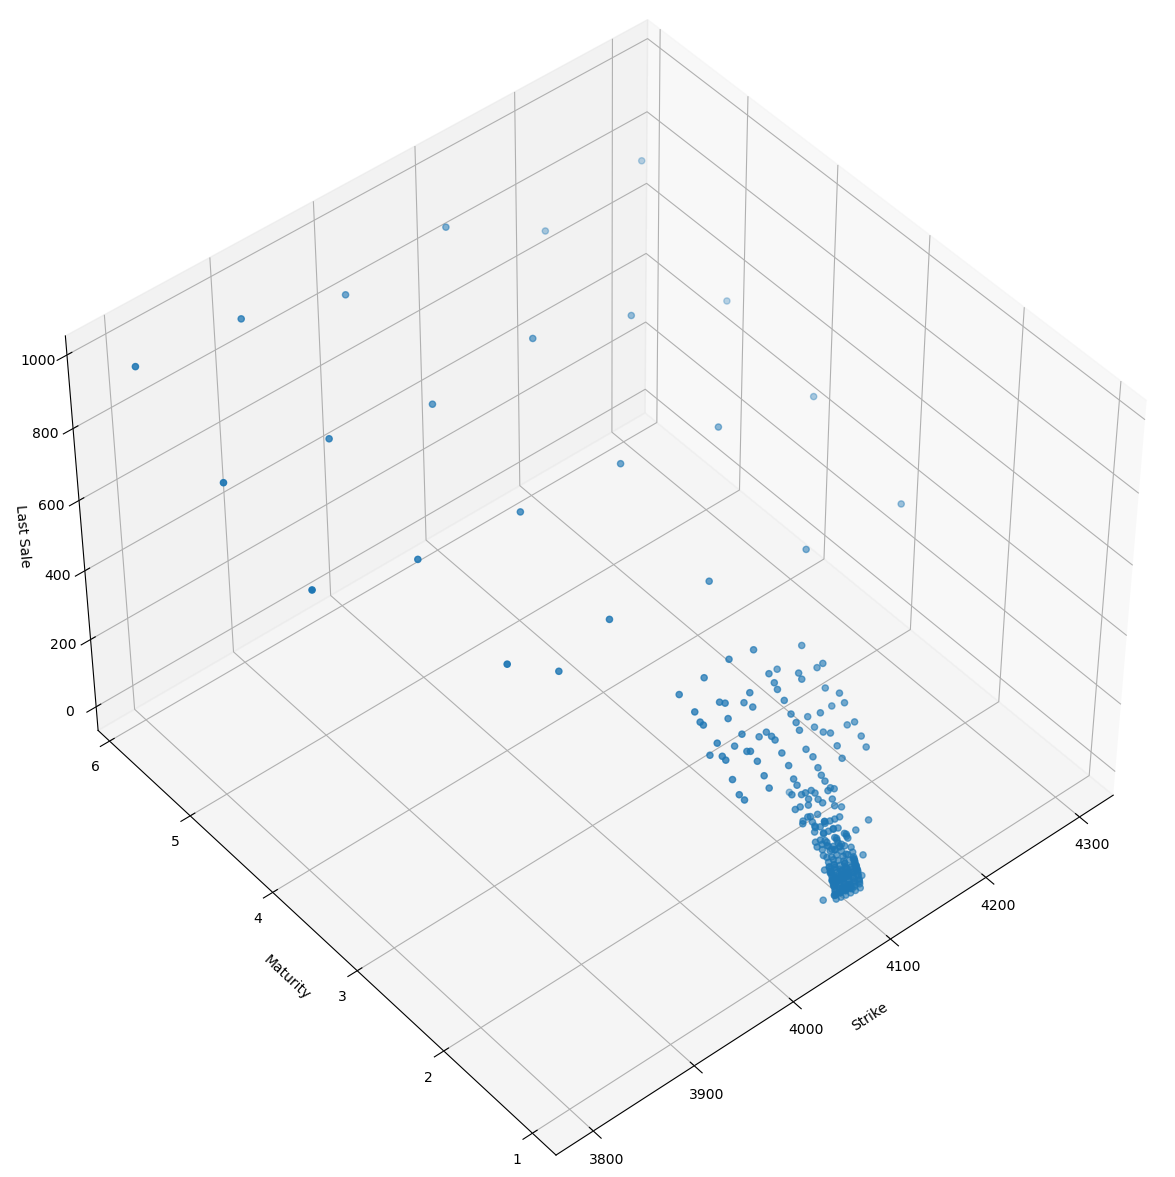

In [51]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Last Sale'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Last Sale'], cmap=cm.coolwarm)
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Last Sale')

plt.show()

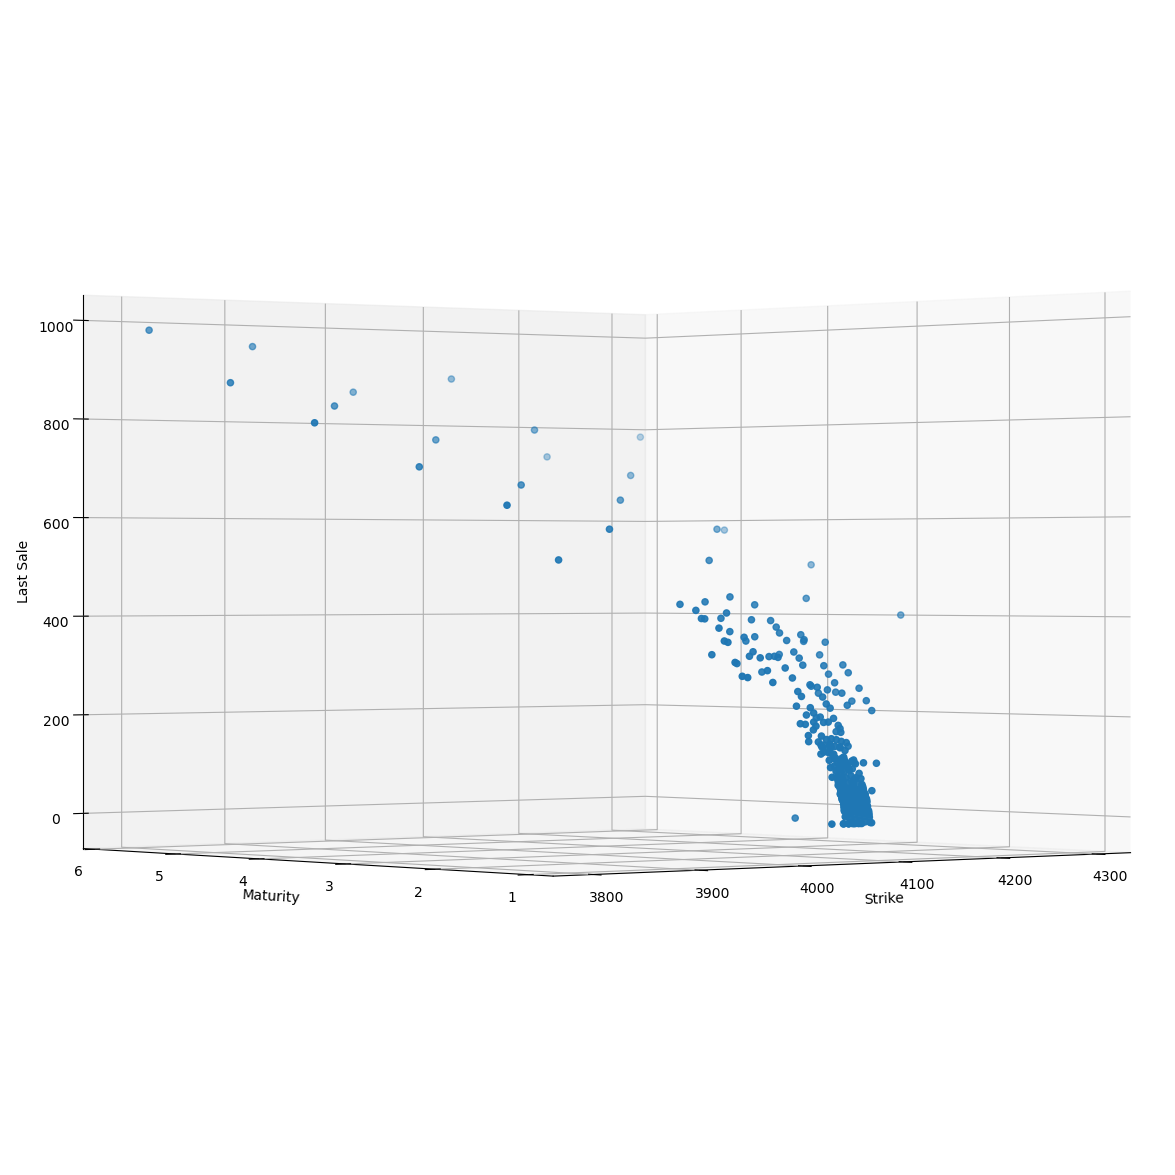

In [52]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Last Sale'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Last Sale'], cmap=cm.coolwarm)
ax.view_init(elev=0, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Last Sale')

plt.show()

### Keeping the OTM

In [64]:
spot = 4100
callPrices[callPrices['Strike']>=spot]

,Last Sale,Strike,Maturity
Expiration Date,,,
2023-03-31,1.98,4100.0,1.082192
2023-04-03,11.90,4100.0,1.090411
2023-04-04,17.20,4100.0,1.093151
2023-04-05,21.50,4100.0,1.095890
2023-04-06,25.00,4100.0,1.098630
...,...,...,...
2026-12-18,692.40,4200.0,4.802740
2026-12-18,578.80,4300.0,4.802740
2027-12-17,896.31,4100.0,5.800000


In [65]:
callPrices


,Last Sale,Strike,Maturity
Expiration Date,,,
2023-03-31,14.62,4075.0,1.082192
2023-03-31,11.13,4080.0,1.082192
2023-03-31,8.03,4085.0,1.082192
2023-03-31,5.43,4090.0,1.082192
2023-03-31,3.50,4095.0,1.082192
...,...,...,...
2027-12-17,952.52,3900.0,5.800000
2027-12-17,863.71,4000.0,5.800000
2027-12-17,896.31,4100.0,5.800000


### Building the marketprice matrix

In [53]:
strikes = pd.Series(callPrices['Strike'].unique()).sort_values().to_list()
maturities = pd.Series(callPrices['Maturity'].unique()).sort_values().to_list()
lenK = len(strikes)
lenT = len(maturities)

In [54]:
#marketPrices = np.zeros((lenK, lenT))

marketPrices = []
strike_m = []

#for i in strikes: 
for j in maturities: 
        #print(i, j)
        strike_m_temp = callPrices[(callPrices['Maturity']==j)]['Strike'].to_list()
        marketPrices_temp = callPrices[(callPrices['Maturity']==j)]['Last Sale'].to_list()
        
        marketPrices.append(marketPrices_temp)
        strike_m.append(strike_m_temp)
        

In [55]:
strike_m



[[4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4080.0, 4085.0, 4085.0, 4090.0, 4090.0, 4095.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.0, 4095.0, 4100.0],
 [4075.0, 4080.0, 4085.0, 4090.

# Heston model:

#### Parameters
κ is the mean reversion speed, 
θ is the long run variance,
σ is the volatility of the volatility.

In [56]:
#Contract Parameters
S0 = 4100
K = 80
k = np.log(K)
r = 0.05
q = 0.015

# Parameters
alpha = 1.5
eta = 0.2

n = 12
N = 2**n
# step-size in log strike space
lda = (2*np.pi/N)/eta

#Choice of beta
beta = np.log(S0)-N*lda/2
#beta = np.log(K)

# Model
model = 'Heston'

kappa = 2.75
theta = 0.0625
sig = 0.25
rho = -0.65
v0 = 0.05

params = []
params.append(kappa)
params.append(theta)
params.append(sig)
params.append(rho)
params.append(v0)

In [57]:
#Generating Option Price Surface Under A model from the list         
def generic_CF(u, params, T, model):
    
    if (model == 'GBM'):
        
        sig = params[0];
        mu = np.log(S0) + (r-q-sig**2/2)*T;
        a = sig*np.sqrt(T);
        phi = np.exp(1j*mu*u-(a*u)**2/2);
        
    elif(model == 'Heston'):
        
        kappa  = params[0];
        theta  = params[1];
        sigma  = params[2];
        rho    = params[3];
        v0     = params[4];

        tmp = (kappa-1j*rho*sigma*u);
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2);
        
        pow1 = 2*kappa*theta/(sigma**2);

        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*r + 1j*u*math.log(S0);
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2));
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp);
        log_phi = numer1 - log_denum1 - tmp2;
        phi = np.exp(log_phi);

    elif (model == 'VG'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];

        if (nu == 0):
            mu = math.log(S0) + (r-q - theta -0.5*sigma**2)*T;
            phi  = math.exp(1j*u*mu) * math.exp((1j*theta*u-0.5*sigma**2*u**2)*T);
        else:
            mu  = math.log(S0) + (r-q + math.log(1-theta*nu-0.5*sigma**2*nu)/nu)*T;
            phi = cmath.exp(1j*u*mu)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu));
            
    elif (model == 'VGSA'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];
        kappa  = params[3]; 
        eta    = params[4];
        lbda   = params[5];

        if (nu == 0):
            mu = math.log(S0) + (r-q - theta -0.5*sigma**2)*T;
            phi  = math.exp(1j*u*mu) * math.exp((1j*theta*u-0.5*sigma**2*u**2)*T);
        else:
            mu  = math.log(S0) + (r-q + math.log(1-theta*nu-0.5*sigma**2*nu)/nu)*T;
            phi = cmath.exp(1j*u*mu)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu));

    return phi

In [58]:
def genericFFT(params, T, model):
    
    # forming vector x and strikes km for m=1,...,N
    km = []
    xX = []
    
    # discount factor
    df = math.exp(-r*T)
    
    for j in range(N):
        
        nuJ=j*eta
        km.append(beta+j*lda)
        
        psi_nuJ = df*generic_CF(nuJ-(alpha+1)*1j, params, T, model)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        
        xX.append(cmath.exp(-1j*beta*nuJ)*psi_nuJ*wJ)
     
    yY = np.fft.fft(xX)
    
    cT_km = []    
    for i in range(N):
        multiplier = math.exp(-alpha*km[i])/math.pi
        cT_km.append(multiplier*np.real(yY[i]))
    
    return km, cT_km


In [59]:
# function for the search: 
def myRange(start, finish, increment):
    while (start <= finish):
        yield start
        start += increment
        
def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

In [60]:
'''lenK = 11
lenT = 13

strikes = 70. + 5. * np.arange(lenK)
maturities = 0.2 + 0.05 * np.arange(lenT)

marketPrices = np.zeros((lenK, lenT))

for i in range(lenT):
    T = maturities[i]
    [km, cT_km] = genericFFT(params, T, model)
    marketPrices[:,i] = np.interp(np.log(strikes), km, cT_km)'''

'lenK = 11\nlenT = 13\n\nstrikes = 70. + 5. * np.arange(lenK)\nmaturities = 0.2 + 0.05 * np.arange(lenT)\n\nmarketPrices = np.zeros((lenK, lenT))\n\nfor i in range(lenT):\n    T = maturities[i]\n    [km, cT_km] = genericFFT(params, T, model)\n    marketPrices[:,i] = np.interp(np.log(strikes), km, cT_km)'

GRID SEARCH TO FIND THE OPTIMAL PARAMETERS:

In [62]:
#modelPrices = np.zeros((lenK, lenT))
modelPrices = []

#start_time = time.time()

maeMin = 1.0e6
'''for kappa in tqdm(myRange(2.5,3.0,0.25)):
    print(kappa)
    for theta in myRange(0.06,0.065,0.0025):
        for sig in myRange(0.1,0.3,0.05):
            for rho in myRange(-0.675,-0.625,0.025):
                for v0 in myRange(0.04,0.06,0.01):'''
for kappa in tqdm(myRange(1.0,3.0,0.25)):
    print(kappa)
    for theta in myRange(0.02,0.06,0.01):
        for sig in myRange(0.05,0.1,0.05):
            for rho in myRange(-0.675,-0.625,0.025):
                for v0 in myRange(0.04,0.06,0.01):
                    tmp_params = []
                    tmp_params.append(kappa)
                    tmp_params.append(theta)
                    tmp_params.append(sig)
                    tmp_params.append(rho)
                    tmp_params.append(v0)
                    mae = 0;
                    for j in range(lenT):
                        T = maturities[j]
                        #print tmp_params, T
                        [km, cT_km] = genericFFT(tmp_params, T, model)
                        
                        tmp_strikes = strike_m[j]
                        tmp_marketPrices = marketPrices[j]
                        tmp_modelPrices = np.interp(np.log(tmp_strikes), km, cT_km)
                        modelPrices.append(tmp_modelPrices)
                        #print(tmp_modelPrices)
                        #print(tmp_marketPrices)
                        
                        
                        #modelPrices[:,j] = np.interp(np.log(tmp_strikes), km, cT_km)
                        tmp = tmp_marketPrices-tmp_modelPrices
                        #modelPrices[:,j] = np.interp(np.log(strikes), km, cT_km)
                        #tmp = marketPrices[:,j]-modelPrices[:,j]
                        mae += np.sum(np.multiply(tmp, tmp))
                        print(mae)
                        
                        
                        
                        
                    if (mae < maeMin):
                        maeMin = mae
                        params2 = tmp_params

#end_time = time.time()
#print('Duration:', end_time-start_time)
                        
print(params2)

0it [00:00, ?it/s]

1.0
1050601.0350471956
2057174.1479639234
3044777.6934557324
4010633.2768468084
4963515.979446104
5891230.644333732
6807031.45127647
7693854.542384528
8618169.192682497
9489194.23714668
10352118.649373705
11241983.509065516
12214658.511394015
13056709.720577043
13888117.723830879
14838370.71351872
15895287.914368657
16946760.251942273
17824035.4585677
18620650.57996716
19412966.417230237
20401652.281046562
21152012.7876622
21889638.55581507
22595363.984405294
23389521.62347026
24107005.961787794
24774629.89719112
25445046.115017783
26073283.849725947
26677345.89472729
27352060.770077188
27980740.156458206
28605672.562130358
29187578.95548201
29754430.745144553
30225405.999462266
30671468.235413626
31100859.101120543
31541766.176959064
31943927.460815944
32365671.804808054
32923422.156916186
33332017.31731011
33680601.17550993
34402305.86972079
34832136.147702545
35217284.12232301
35734739.48190535
36419522.36791173
37211861.06652519
1181899.0280155085
2317135.624915234
3432239.56658804

31216554.2143644
31661660.98595175
32068133.40444042
32494407.30084207
33057810.081290692
33471523.535961594
33825044.47367561
34553235.6151732
34989394.74825624
35382886.420352556
35914775.43670185
36619687.02803857
37436768.10502818
1183714.9017093522
2320763.5590097983
3437675.3931839284
4531482.694689488
5611511.559678512
6664850.314955835
7705519.35149315
8715309.938086983
9764995.381688343
10757976.140522234
11742382.714355825
12755564.077196958
13856799.303940075
14818973.772376213
15769795.101591848
16847141.154812045
18037906.78422238
19222851.817132227
20222556.957556956
21136298.90021626
22045485.403815184
23163648.030628115
24027936.98225807
24878668.48302297
25695235.56022166
26606057.98872491
27435403.04455222
28211118.26845085
28989909.43615335
29723261.52562488
30430575.7225284
31214087.385439415
31947963.82126158
32677634.510476653
33360851.807064753
34027668.69012108
34590098.03733235
35125086.01663429
35641552.18375602
36170186.00566724
36656304.94272225
37163327.360

30410640.934441537
31268212.740263786
32079064.32660399
32865182.94555669
33735256.929775745
34555008.70762453
35373332.67891451
36144973.03271483
36901824.80559994
37549474.24889712
38170806.456541725
38776372.609448045
39399388.142044455
39978011.08584772
40582302.87286695
41351349.96879544
41946968.18974579
42471195.07815496
43424864.756111756
44056594.915282376
44647140.476984166
45423221.53525646
46419784.287018
47555250.355561286
1137008.093698591
2228972.6384219863
3301432.478927044
4351478.594261276
5388248.725200384
6399756.707897993
7399070.28121862
8368347.251513905
9376972.693246141
10330214.149442023
11275702.478541072
12249618.992797706
13310189.892382925
14234535.98825211
15147967.02843015
16186274.678588409
17336219.673051115
18480703.305586144
19443448.40155444
20322014.444911886
21196747.547535695
22277068.23691038
23108597.09272404
23928271.114943337
24715834.46002737
25597693.23447023
26400289.393237874
27150538.190743778
27905198.798527893
28616550.86845387
2930497

16310539.884463662
17430027.43640441
18665549.96551474
19895596.655155644
20937262.595438704
21891625.001841236
22842598.155551665
24007316.35356856
24913999.303392537
25809656.161683522
26673065.961267486
27636015.38906999
28517428.35568102
29344329.615950033
30177398.73695125
30965861.44254459
31732704.7250286
32586945.77688429
33393370.708769232
34202102.84222654
34967022.32403122
35720205.82835289
36367045.72901115
36991386.14945589
37604925.53309637
38241086.149192646
38834816.19700168
39458219.85171185
40254332.0071519
40878682.10709952
41432005.13989673
42427208.92196794
43105460.04549438
43768612.85550558
44679891.73062561
45873468.52629994
47252921.67107621
1345039.8287668624
2641760.946028703
3917449.772703401
5168916.76106576
6406117.171565519
7616612.388622451
8813989.25665117
9978686.759371048
11186555.728518257
12334104.756567286
13473795.74293584
14644871.951717231
15910737.887206603
17027837.706365388
18133154.798290376
19375588.689620283
20740101.348567884
22098794.987

6408333.889826843
7619290.2686606785
8817130.15517091
9982288.888968658
11190627.320335262
12338643.926491603
13478814.918346887
14650385.58203981
15916761.99763701
17034352.640853036
18140161.275401182
19383126.97724018
20748205.494666804
22107471.031483
23268427.522023648
24337317.240876198
25402598.27880052
26692949.84997573
27711313.94226601
28717943.015165206
29690328.04558675
30767488.197944358
31758841.105546538
32692326.315528333
33632268.20280434
34524732.68617252
35393999.161042206
36355679.864411846
37266411.50731734
38179130.24156208
39045089.03835331
39898203.71481677
40637610.73467101
41352444.12898276
42055033.95523409
42780946.97909202
43461275.15479665
44172506.354321495
45066662.15810539
45777465.19705477
46412098.47314833
47508935.37669396
48274010.53731628
49017279.41008917
50011595.70748583
51290356.35089928
52753489.82564667
1298753.6772220284
2550729.056649278
3782270.1522691348
4990241.937691278
6184424.836780966
7353273.412575119
8509456.14343319
9633751.862729

51566972.47237079
52465716.74135622
53362583.71288335
54573919.5567352
56131302.8561502
57917116.45791828
1299781.1145342872
2552778.341547133
3785338.3039277256
4994322.955477975
6189516.939042812
7359383.374679472
8516582.377890363
9641884.414384218
10809881.12114001
11918777.595501075
13020622.194495564
14153564.316616705
15380049.087152267
16460352.673014421
17529289.070882168
18733923.376150668
20059059.675602823
21378726.3910589
22503293.71727436
23537436.29529787
24568674.653673057
25821911.15323863
26807837.09728396
27783688.204325467
28727275.954164833
29775793.59613515
30740598.93103785
31648733.7605074
32564656.326511756
33435159.982330978
34285541.41996294
35231817.8002193
36129608.49448513
37033106.82259847
37892691.09148342
38742480.34520461
39481398.29234229
40199591.29114489
40910572.122755684
41650123.57222279
42346121.158359595
43077091.20424814
43998898.13639348
44739316.01475393
45404100.843614876
46543136.32380846
47356103.41135988
48174897.901379384
49309761.19243

1it [02:20, 140.17s/it]

57857183.474055596
1.25
1022815.5193862439
2002031.4845768725
2962485.19042299
3901440.2903913707
4827552.421626324
5728648.712485723
6617952.920324253
7478655.1260535745
8376271.591308955
9221312.70954804
10058229.0487245
10921633.667845512
11866629.691549445
12682849.268086541
13488542.58585073
14411221.852336505
15438994.479043813
16461360.907514248
17311986.05754396
18083114.960813157
18849881.097512774
19810094.72454443
20535422.12913549
21247935.990274917
21928817.08787108
22696491.812044114
23388453.67013408
24031385.35960681
24676776.488474656
25280576.36123187
25860203.756359775
26508437.96614161
27111238.02380897
27709895.69923895
28266059.68236778
28807127.496871598
29254305.218323
29676813.98955458
30082601.265161067
30499151.098257832
30877850.456842963
31275356.631097578
31804795.951107223
32188872.134100568
32514700.449926425
33205634.502017092
33609649.6112669
33970367.95907494
34460858.58650367
35117222.79402712
35881905.374233745
1141318.0573888216
2236544.4619867867


30631755.40877309
31014958.173596192
31417191.006968513
31952503.229645986
32341848.979673523
32672724.90082007
33370372.626348637
33780787.56395481
34149610.18349633
34653513.763876654
35328135.878998175
36114807.34408557
1143624.5327889218
2241147.3507879423
3318809.393177983
4373700.361764863
5414983.673200107
6429759.572336227
7432025.573273017
8403918.934786055
9414914.837850435
10370172.863357833
11316805.801379403
12291591.16456125
13352764.064901503
14277387.393212132
15190811.15232227
16228208.318721987
17376877.749617282
18519773.152158298
19480771.032086745
20357385.85580139
21229341.571391877
22306283.195875775
23134022.81639736
23948058.39019995
24728256.04025555
25600436.453016605
26392422.476349033
27131901.4090447
27873971.300680846
28571361.476342134
29242651.571103845
29987241.03715793
30682976.486751825
31373884.714740705
32019019.29927773
32647641.22620001
33174547.23090094
33674274.80572349
34155328.282840095
34647448.05522613
35098236.91796015
35568821.69684413
36

31305595.213577654
32067251.106912613
32910939.089914117
33704768.22639186
34496715.43701226
35242366.10690261
35973106.25589206
36596298.90046691
37193269.4627104
37774282.154833674
38371952.73192149
38925935.8727417
39504819.49594804
40244784.21369208
40814509.19290898
41314322.26170801
42236546.98129485
42840913.989001594
43404884.95373161
44151946.65135034
45118322.55426395
46224476.57668119
1123357.7446442852
2201867.8163802167
3260968.6438098946
4297771.179218311
5321356.929477117
6319744.179584462
7305992.333279018
8262378.524761943
9257840.456946515
10198251.402455553
11130891.739547005
12091745.265972005
13138679.57386822
14050254.159721792
14950966.769659547
15975676.859375749
17111283.934432514
18241445.467879355
19191021.17568076
20056961.06128543
20919032.369633894
21985317.279021453
22804417.487978216
23611610.307926346
24386801.76425274
25255505.8461451
26045383.68781546
26783299.01679092
27525470.51476458
28224568.413052306
28900713.899867512
29655420.090362623
30363264

19889363.344022136
20930672.646347035
21884690.83271382
22835316.102423817
23999649.35860735
24905986.086022027
25801288.097146146
26664338.593935907
27626900.30738123
28507931.24132419
29334459.590654302
30167153.87697365
30955227.637928925
31721668.887145
32575443.818745434
33381406.069522787
34189637.869284034
34954055.523995966
35706718.62096529
36353055.63298179
36976867.37000857
37589839.61564204
38225388.56251949
38818492.142340876
39441229.91708864
40236529.05807087
40860114.998428665
41412690.7869554
42406937.91140616
43084222.37868127
43746047.86325091
44654935.655423194
45845105.36502145
47220284.21002303
1331654.0754582887
2615156.4138950147
3877709.36853987
5116141.304758794
6340356.828323713
7537911.931733802
8722395.366170486
9874353.647456674
11069234.27243798
12204092.14841382
13331066.883344078
14489230.222069988
15741662.975102313
16846106.231167898
17938811.39627091
19167831.98158634
20518261.52085088
21862883.37465379
23010277.89807328
24066100.03822499
25118263.02

12212580.690532364
13340426.387792643
14499481.5297895
15752839.372035012
16858163.948857937
17951750.360201
19181719.26537997
20533152.48092483
21878784.082137097
23027110.081090704
24083840.64507457
25136924.003094263
26413877.01453605
27420236.90503868
28414798.772855505
29375194.805460252
30439667.45127269
31418700.851796184
32340196.900761895
33267998.370416507
34148509.57987098
35005765.85274555
35954499.28519733
36852493.95436682
37752224.49750804
38605363.8828768
39445580.85583972
40172833.379523546
40875514.89854577
41565813.518277474
42279033.03501353
42946946.20562842
43645380.27500111
44524976.593399495
45222641.5541526
45844782.89211536
46925894.29257022
47676952.55200857
48406081.714218244
49384018.819770046
50644820.92223577
52089352.57981957
1311594.1192818284
2576239.584011289
3820367.4608139647
5040825.645814683
6247443.709462031
7428673.618234851
8597189.969456976
9733667.500291288
10913061.259803837
12033080.136686843
13146054.558517704
14290291.877721637
15528536.1

1312822.6417631246
2578689.587753525
3824034.983123901
5045703.562534622
6253529.84584354
7435975.356824616
8605705.375394858
9743384.628320975
10924002.336304432
12045224.344727252
13159412.697443854
14304888.652070051
15544417.516576493
16636999.548152022
17718168.87118722
18935815.944791134
20274618.180549175
21607936.765168443
22745142.594885092
23791442.97508112
24834874.9307693
26101516.92596699
27099433.66428914
28087328.896013424
29042871.304545954
30104039.0750547
31081112.79024831
32001182.815018784
32929224.760819256
33811594.10744509
34673891.754418105
35632953.81702809
36543335.2558777
37459613.931847
38331821.54143699
39194297.23186527
39945160.83817765
40675259.59184242
41398244.01453907
42150181.58046388
42858228.296902165
43601607.542419605
44537400.63515816
45290428.69695332
45967172.87992897
47121239.650409885
47947397.316744104
48778669.48966334
49925510.827059574
51419298.558460325
53144561.832097605
1426238.9984308816
2803418.6059821835
4159155.206788287
5490150.3

2it [04:45, 143.07s/it]

53314167.28776104
54521316.169353664
56072679.4403503
57850725.91943381
1.5
998930.7209608292
1954660.7376284115
2891817.363554411
3807700.6730562407
4710862.3756880015
5589174.01846369
6455807.579526049
7294173.285881289
8168960.965235068
8991800.690700315
9806519.1594355
10647342.652232837
11568711.193935864
12362909.898347268
13146691.530853173
14045876.992078472
15048807.574929165
16046374.250176702
16874328.29930634
17623798.58017057
18368875.038758755
19304888.2069399
20009002.168181192
20700288.629848078
21360225.168525957
22105606.082439005
22776133.87020095
23398355.41145351
24022804.895731814
24606212.801897492
25165550.655301105
25791919.31854937
26373431.7388037
26950597.45075223
27485803.01261456
28005978.336575203
28433993.908261135
28837665.545077007
29224733.62805969
29622107.34470881
29982427.20380168
30361038.498808824
30868482.74839028
31233716.50710002
31542152.88876239
32209501.68927733
32594096.136117566
32937071.442589622
33408721.40498853
34045601.37598933
34791

28130031.056570023
28562020.87535411
28969786.064014055
29361133.77218316
29763017.529925294
30127892.48603398
30511278.26694382
31024636.215821173
31395135.171679962
31708587.357002832
32382667.161471214
32773563.14926962
33124273.7302965
33608304.389729224
34261734.04676978
35027267.57296359
1109091.037386817
2172612.6722812844
3216527.579752115
4237975.492055233
5245977.463958668
6227681.049915943
7197026.505470717
8136452.809352482
9114302.81552268
10037270.103224028
10951604.028886653
11893560.46280067
12920466.100232469
13813020.018772123
14694519.879291099
15697811.166512515
16810521.391462453
17917511.070656408
18845518.701485995
19690527.134167455
20530821.636776794
21572653.93303683
22369369.285268437
23152333.750993114
23901821.459312163
24741413.72109079
25501972.841523107
26211012.098138746
26922304.58593775
27589642.068675995
28230975.968186036
28943371.961747754
29607683.722049702
30266833.66501651
30880915.58181425
31478541.86661198
31976810.431445725
32448306.85839761


22681342.381778147
23833021.292937275
24727319.87454749
25608738.792138796
26456279.40809147
27400581.574248184
28262705.14939825
29070399.18952701
29882349.30543183
30648494.709625453
31389840.990463294
32211750.701014653
32984259.761414178
33754632.51334022
34479117.90939832
35188691.063666075
35792165.406746075
36369619.8549338
36931120.55033738
37508796.792374484
38043426.815602355
38602453.94485732
39319797.00818937
39869564.48431709
40350642.47499744
41248744.21568909
41832461.52062966
42377041.06533044
43103751.354990564
44049368.112011164
45135545.722855255
1111605.869033717
2178545.1445027953
3226161.5357182333
4251583.215352137
5263843.025040376
6250974.169917801
7226017.6446112795
8171353.480486275
9155533.526240464
10084953.314923557
11006598.223360104
11956274.771456687
12991542.054959867
13892197.769420821
14782040.735093558
15795136.213864481
16918496.285170272
18036428.325339343
18974768.351110563
19829942.445926994
20681227.854470003
21735552.301413614
22544080.1642353

11099557.058575645
12120665.7292811
13171505.96885912
14312399.628422769
15312140.729265695
16300736.893808907
17419523.772157546
18654306.383362222
19883611.47573145
20924592.576991666
21878294.085666742
22828599.49570262
23992578.88245069
24898597.564901873
25793574.091364972
26656295.51163507
27618502.609214757
28499184.542825148
29325372.359971963
30157724.438537557
30945444.21324887
31711520.50451828
32564874.44909848
33370419.396159887
34178201.89970951
34942169.81101424
35694367.8127988
36340256.58581825
36963599.13132797
37576070.73870027
38211082.14155877
38803637.16642399
39425793.74565409
40220387.151189506
40843312.915000334
41395244.891580544
42388669.17691052
43065132.03997007
43725862.19281799
44632862.86096774
45820421.78243499
47192397.43285303
1320178.2837540328
2592360.3146242406
3843668.154104973
5070945.524683966
6284053.425417654
7470554.511672069
8644027.760869578
9785111.917580992
10968908.461366797
12092940.827676268
13209079.578691378
14356242.228048086
155972

47337991.69451527
1321328.135082717
2594659.591553
3847115.144971192
5075535.525424974
6289786.362896563
7477445.15481808
8652076.194478435
9794308.656720007
10979276.714567732
12104462.456887068
13221770.482447892
14370127.945643729
15612359.612087268
16707207.6115032
17790358.47473071
19009237.80030411
20349029.08676455
21683032.217433672
22820593.14679347
23866965.70946846
24909668.09914096
26175216.277886752
27171373.788191903
28155702.239927907
29105953.98029445
30159711.4086387
31128358.174600884
32039754.00249984
32957349.807581283
33827834.15978946
34675058.23554603
35613037.86492267
36500485.52104104
37389513.961142905
38232129.888838015
39061802.19799433
39779159.30447606
40472001.76234314
41152418.0676167
41855499.28172492
42513530.075277805
43201824.69270545
44069943.91059217
44757321.86896163
45369711.84668655
46438581.26181376
47178861.124865994
47897400.6208939
48863422.76286773
50111317.003085695
51542539.42074184
1322527.318290264
2597950.7228157725
3852782.415057176
5

44505717.94934433
45305197.04973545
46133870.98306363
46915860.53457932
47733926.465833865
48751923.43206374
49577765.14216786
50323130.34755073
51561385.192316845
52459301.833200455
53354508.81968449
54561760.12258757
56112691.57461388
57889706.60351095
1323910.9257235823
2600709.5091818944
3856911.569572863
5089347.352429853
6307893.564267196
7500999.520965239
8681345.8470573
9829508.19309221
11020810.81837142
12152465.28899119
13277090.845060088
14433160.313286135
15683708.075273335
16786661.857577633
17878161.196683925
19106782.28608251
20457102.75443771
21801923.885028217
22949778.92246399
24006322.09345556
25060016.53553683
26337931.729116127
27345927.70987015
28343923.23351825
29309468.138561208
30381192.61171845
31368489.390724212
32298499.948572177
33236612.683174986
34128819.905068174
35000952.90697425
35970492.49843113
36891160.83329294
37817821.20753094
38700243.395725526
39572937.613462396
40333386.57651821
41072979.17206505
41805456.77949869
42567110.172725424
43284572.04

3it [07:02, 140.20s/it]

56067281.44971694
57841684.176286496
1.75
978315.9336543726
1913799.7775378088
2830881.6883047866
3726893.369578414
4610295.864423819
5469019.100313795
6316169.991892201
7135350.141350708
7990530.721167715
8794315.172737418
9590000.542545466
10411464.595633978
11312572.087888619
12087910.280303491
12852932.376560684
13732006.02545933
14713663.452603018
15690000.547341814
16498574.881171888
17229548.1546865
17956119.080637906
18871462.211769324
19557506.28285724
20230752.178606573
20872932.401768953
21599438.575261608
22251858.65595798
22856604.29688283
23463419.157233883
24029699.5058304
24572071.21395114
25180248.470841594
25744110.49498008
26303545.33577642
26821531.47727229
27324613.50238154
27737037.19739139
28125471.789231036
28497507.596122243
28879577.936828706
29225291.866824027
29588949.20726475
30079034.580698337
30429531.211043127
30724426.031201914
31373365.475742266
31743026.60943243
32072714.394146074
32530597.21504286
33153369.079589013
33885701.07227924
1076284.26269674

26424150.77442032
26946346.122454874
27453715.489600554
27870153.54937958
28262703.43761756
28639020.341447607
29025591.433495756
29375826.413866118
29744216.00927837
30240148.512423754
30595816.927910805
30895616.727321897
31551183.18646612
31926959.490758613
32263970.57866154
32733274.72239526
33371104.222380035
34121113.62246405
1079225.6959453684
2113379.121018314
3128158.462398994
4120747.1468949313
5100041.362487606
6053259.045816353
6994261.000119638
7905749.9387220405
8855078.65317432
9750281.598737549
10636872.127404967
11550631.959510026
12548095.329975987
13413134.20616671
14267255.199727995
15241293.843241747
16323146.596682943
17399335.539242268
18299090.972562835
19117061.119998053
19930296.7818684
20942081.378310498
21712327.127674703
22468842.70763048
23192254.777043253
24004208.812543366
24738175.467632193
25421490.30672297
26106826.560828302
26748886.21411541
27365135.917575046
28050704.21811454
28688921.59058855
29321829.96681723
29910361.75032491
30482592.133270755


22281532.337408673
23413226.706195205
24289790.336926818
25153472.915583212
25983497.699970003
26909286.701542936
27753544.62852824
28543914.550095923
29338377.04429963
30087450.885479733
30811816.919954084
31615614.860454295
32370449.21722193
33123023.95036552
33830116.11940941
34522365.016680874
35109776.84286594
35671421.83286908
36217225.81583555
36778917.46669806
37298132.601133674
37841410.709949136
38540881.758743554
39075000.286363
39541440.194116585
40420698.777318515
40988495.6406961
41518496.92014087
42230291.25609479
43160840.033885956
44232566.36085188
1101446.1368538155
2158392.126052696
3196093.1994221467
4211692.429512109
5214180.393221904
6191611.982370857
7157003.359987946
8092823.614526572
9067290.56050586
9987251.703005033
10899442.760760069
11839511.341740675
12864750.11937312
13756026.556789381
14636535.554817142
15639662.568766883
16752511.569395324
17859950.711486235
18788657.786463518
19634606.71879345
20476657.80051363
21520739.391704105
22320227.397203058
231

7938444.460187883
8982938.204325175
10068422.257608023
11096679.66767804
12117500.86380313
13168048.052652868
14308636.003680058
15308088.913267605
16296397.368335038
17414875.2839722
18649331.739877935
19878310.04851976
20918989.441146348
21872399.91561793
22822411.53498605
23986065.949302476
24891792.75801765
25786471.006120276
26648891.287429478
27610774.2981607
28491137.634750254
29317014.703351196
30149054.619339358
30936452.374693967
31702197.482491247
32555171.185928732
33360339.73150915
34167718.58934016
34931283.22146245
35683065.259350136
36328554.13349226
36951479.735260025
37563508.60988863
38198046.58816834
38790120.0202094
39411767.84014296
40205746.44884525
40828099.525659464
41379474.324457474
42372187.65378214
43047947.84882665
43707764.233511955
44613246.021591194
45798750.46011588
47168246.39828633
1310297.237658364
2572741.9013673
3814380.374667486
5032069.596107064
6235632.88178052
7412647.556027585
8576675.136406435
9708433.78433887
10882726.949710488
11997481.490

42475700.682535425
43155682.94412703
43821004.89197364
44735515.10470371
45933012.31073768
47316844.336494185
1311685.9598842748
2575515.8791467664
3818536.319457963
5037600.982826751
6242538.730781426
7420941.766226608
8586356.942954201
9719490.858720053
10895187.331813056
12011321.269118298
13119577.55911553
14258747.957018225
15491425.843393758
16577282.830534926
17651480.71055742
18860851.85401344
20190662.27627059
21514699.039331004
22643039.35866007
23680544.082834665
24714366.704825863
25970158.109307006
26957599.467786163
27933202.804677047
28874823.08922229
29919478.9631464
30879316.895779245
31782152.799786687
32691116.222848024
33553135.7182779
34391922.53910658
35320903.91377003
36199550.174377546
37079686.69985141
37913587.95865282
38734559.130420625
39443780.47283449
40128571.74887093
40800949.78376443
41495830.624313645
42145890.489173226
42826038.25638134
43684974.31320068
44364166.106863245
44968814.989791945
46027987.282630555
46759810.30758792
47470197.46328372
48427

41915202.43030017
42863744.08801397
43694491.10812134
44502449.17460793
45301715.21497147
46130157.85570947
46911890.76042592
47729683.56772706
48747329.883222714
49572827.51519415
50317842.266961455
51555681.53631015
52453114.637606904
53347502.883115806
54553021.62149744
56101391.116313994
57875092.58434668
1333382.071694852
2619509.487240577
3884973.668787585
5126592.604104746
6354278.876118216
7556462.741169003
8745846.657058707
9902930.81195963
11103323.398863442
12243851.111482732
13377345.461646132
14542413.110335954
15802315.897386657
16914074.713395566
18014341.037441853
19252264.460305747
20612343.57400922
21966907.02852804
23123781.688385334
24188998.983911455
25251375.99568936
26538822.047046006
27555335.591793537
28561847.829623774
29535809.14734373
30616395.100636903
31612261.436695315
32550600.78874746
33497133.75314612
34397549.17894848
35277854.36657958
36256042.949577674
37185179.70343216
38120341.773477234
39011099.566349275
39892098.13323611
40660309.99131848
414075

4it [09:18, 138.74s/it]

56059941.65293415
57831306.57409743
2.0
960449.7901193142
1878406.3452321491
2778116.25466035
3656938.7716005985
4523255.610539113
5365063.182020122
6195395.833185452
6998022.0394647885
7836286.1201691395
8623640.298091609
9402929.679703554
10207718.521639267
11091370.896616353
11850478.184513696
12599362.133474488
13461136.526950214
14424490.458276333
15382567.346072631
16174493.836682377
16889590.81730269
17600292.260636628
18497892.898331374
19168463.88961107
19826293.92845349
20453335.14221126
21163768.742481478
21800799.344375823
22390707.84106749
22982578.879606742
23534378.618574016
24062463.105689414
24655390.85410478
25204501.430742007
25749182.868570894
26252892.938091338
26741855.275406867
27141460.536711764
27517431.95430877
27877247.706094336
28246942.65818419
28580886.805863254
28932534.565470755
29408709.722291317
29747483.98875551
30031646.913028944
30665963.913560912
31023903.004825853
31343359.999475654
31790797.24922377
32402905.628596943
33124998.236400113
1050157.1

25872721.644413203
26380647.4552839
26873894.557641663
27277497.854504492
27657551.27426827
28021595.329071768
28395725.465267796
28734105.22287727
29090389.696104173
29572282.699169192
29916086.142386828
30205001.365740683
30845773.378668863
31209599.041883808
31535966.16265556
31993962.197086245
32619842.47881989
33357969.854366824
1053292.3672280537
2061973.506583702
3051492.865651854
4019072.1301220376
4973497.685285087
5902071.997219804
6818563.046235792
7705904.694644583
8630581.726326283
9501803.830355491
10364453.879709467
11253883.827974483
12225934.63916631
13067254.700219398
13897783.19925459
14846613.254854692
15901862.832099466
16951506.073777527
17826949.206814546
18621674.089229662
19411667.535948563
20397610.343771674
21145155.067871023
21879034.770345654
22580181.474216715
23368561.125741914
24079892.193605687
24741335.352734137
25404643.962302066
26025302.872766335
26620400.852369335
27283444.622722637
27899821.309752654
28510861.83867901
29078180.91521686
29629404.01

21031478.36203528
21937303.971368235
23051867.134657644
23913257.234713536
24761795.796162244
25576896.581373326
26486934.632420722
27316018.916938536
28091687.852085747
28871338.26097759
29605983.161257878
30316052.2132029
31104672.727875058
31844737.304801866
32582503.465428796
33275172.64634077
33953106.42247162
34527299.72249469
35075996.589662656
35609020.534535885
36157765.93404593
36664534.601215154
37195140.82248666
37880277.409224845
38401921.00643878
38856725.3247303
39721007.05526829
40276278.82208856
40795019.17509509
41495468.20436832
42414605.4232657
43475398.55985063
1092625.1715791193
2140902.570112704
3170005.3649644386
4177089.570081675
5171108.918583138
6140144.079960009
7097182.595598936
8024770.935485371
8990836.600062173
9902619.784992794
10806643.719908377
11738413.627037887
12754991.142939277
13638171.762632558
14510626.424569534
15505155.815226711
16608939.424115486
17707331.314440116
18627738.160844002
19465742.020522468
20299846.45216351
21335111.39552433
221

8980814.289208759
10066030.312457092
11094025.289383555
12114581.77339114
13164859.173558697
14305165.72109588
15304353.417019058
16292397.150595106
17410590.94693716
18644747.53582874
19873425.46210507
20913827.5609192
21866970.621092472
22816712.440457374
23980068.468652245
24885527.45374504
25779932.367330063
26642077.0640694
27603663.856127974
28483736.295359388
29309329.734436586
30141084.855420254
30928189.542244565
31693633.94021522
32546263.869944185
33351092.556669813
34158108.27458522
34921310.74403565
35672720.117597006
36317851.529006034
36940405.75768411
37552042.012649186
38186161.71016837
38777810.82337283
39399011.56388864
40192452.20082426
40814306.01004171
41365196.051690735
42357291.75605573
43032446.86030795
43691492.672850706
44595730.196616225
45779580.76496533
47147105.01957686
1301751.6601413027
2555782.7878368134
3789069.1128088227
4998478.9931195015
6193803.05089041
7362638.356185025
8518524.166824663
9642247.31356177
10808353.476085654
11915118.331231605
1301

43143940.16887144
43808305.69976369
44721038.31796779
45916019.00077664
47296713.718739405
1303322.7577590751
2558918.74992781
3793765.289992665
5004727.325125517
6201601.725078576
7372000.046330236
8529447.321958369
9654717.29394462
10822401.910361784
11930716.722903185
13031160.321330827
14162402.911549803
15386837.606431115
16464940.79941129
17531419.893661983
18732598.33139703
20053809.543685474
21369261.90763023
22489664.59216409
23519538.527361576
24545726.150333103
25793127.691316277
26773083.17516967
27741206.588216107
28675440.904497392
29712320.716475047
30664643.09222765
31560180.369848114
32461796.346204862
33316623.28837256
34148265.24585999
35069660.967285424
35940905.1549892
36813591.94605444
37640212.88074111
38453937.38236807
39156403.968539186
39834537.5655533
40500301.96361338
41188467.1109132
41832014.13467605
42505526.121897325
43357007.1334734
44029581.92579768
44627985.42590261
45679347.12129993
46404407.23304504
47108360.23383382
48058323.210393585
49288930.9417

43690535.41470364
44498283.7441563
45297315.99213571
46125505.44357226
46906963.78009839
47724464.77971198
48741743.70922009
49566884.009856105
50311538.35168285
51548944.6574321
52445892.61645839
53339510.378690876
54543501.62208329
56089680.49946171
57860613.24821254
1341509.8374159841
2635636.054552581
3909039.639333405
5158528.153703266
6394044.854512629
7603996.786279827
8801112.083879158
9965826.650079925
11173990.648432834
12322102.87297303
13463171.210828438
14635920.662632797
15903806.466675768
17023078.353994884
18130823.20203709
19376673.1480994
20745063.800404586
22107922.498575766
23272476.883933537
24345078.614364225
25414840.780174725
26710388.438165385
27734138.900562447
28747872.753173817
29728956.6973704
30817025.596366208
31820119.080353983
32765479.413060516
33719096.92132213
34626405.03596678
35513546.82484902
36498928.20035873
37435090.20092924
38377271.84498241
39274890.55840279
40162699.14748495
40937257.32269621
41690715.52372155
42436917.023451306
43212477.258

5it [11:49, 143.28s/it]

56051497.54001334
57820317.56962514
2.25
944900.5740357307
1847618.2433091025
2732229.7166575636
3596118.3214699836
4447596.145172226
5274730.038272122
6090478.35735094
6878755.568839597
7702357.396731423
8475478.672025915
9240576.842506945
10030934.362480788
10899478.017470166
11644549.900066517
12379483.256294403
13226305.336380254
14173834.99465822
15116129.593864588
15893683.739557557
16595084.730962612
17292107.13283728
18174401.45392231
18831652.846505873
19476237.533877164
20090297.521473054
20786965.011781532
21410837.48107177
21988071.801854033
22567199.02516048
23106675.389914393
23622644.01690753
24202691.84016984
24739376.10582295
25271677.436267212
25763445.52542706
26240633.961058754
26629593.94073199
26995259.763574522
27345023.187478382
27704582.035208073
28028914.214268543
28370780.85840746
28835645.697199486
29164945.55559785
29440460.337090634
30062969.359373298
30411529.3522118
30722912.160396438
31162173.151142742
31765944.780336265
32480033.282454006
1027409.58653

25892618.622901477
26374047.884558648
26766952.812679894
27136632.41177661
27490538.003873054
27854432.655489873
28183085.296314705
28529462.80484296
28999881.291267436
29334042.54925897
29614137.063360687
30242893.433218703
30597095.178964674
30914993.135585684
31364047.459529143
31980484.599783998
32709224.548482012
1030680.194131949
2017174.5889794608
2984700.500039252
3930513.2087566014
4863302.273357604
5770462.443882562
6665661.817431155
7532037.444648455
8435310.852258062
9285724.84712474
10127619.457668956
10995957.759928519
11945972.32836941
12766748.559106927
13576849.679550309
14503852.187178044
15536057.729737427
16562713.475619907
17417131.914705027
18191772.328496095
18961700.21242588
19925308.191904992
20653281.962700468
21367683.81295172
22049711.0861242
22817866.86611315
23509815.416761383
24152549.37186506
24797046.85557494
25399468.959103543
25976606.6173661
26620597.03303624
27218549.399660587
27811213.096377604
28360763.366169933
28894445.424008995
29334225.7670293

5it [12:35, 151.10s/it]

14351532.397414224
15335125.373613771
16427365.528791312


KeyboardInterrupt: 

In [ ]:
#print('Duration:', end_time-start_time)
                        
#old param found 
'''
Duration: 745.8691456317902
[2.5, 0.06, 0.1, -0.675, 0.04]
'''

In [ ]:
print(params2)

In [ ]:
Adapt the code for weighted least-square with the bid and ask spread


## Gradient-Based routines e.g. Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm

In [ ]:
np.shape(marketPrices)

In [ ]:
maturities

In [ ]:
strikes

In [26]:
params = [2.3,     0.046,   0.0825, -0.53,    0.054]

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
[xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(
        mfc.eValue,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF,
        maxiter=20,
        full_output=True, 
        retall=False)

IndexError: index 11 is out of bounds for axis 0 with size 11

### FINDING A STARTING POINT:

In [ ]:
# Periodic Linear Extension
def paramMapping(x, c, d):

    if ((x>=c) & (x<=d)):
        
        y = x

    else:
        
        range = d-c
        n = math.floor((x-c)/range)
        if (n%2 == 0):
            y = x - n*range;
        else:
            y = d + n*range - (x-c)
            
    return y

#def eValue(params, marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model):
def eValue(params, *args):
    
    marketPrices = args[0]
    maturities = args[1]
    strikes = args[2]
    r = args[3]
    q = args[4]
    S0 = args[5]
    alpha = args[6]
    eta = args[7]
    n = args[8]
    model = args[9]

    lenT = len(maturities)
    lenK = len(strikes)
    
    modelPrices = np.zeros((lenT, lenK))
    #print(marketPrices.shape)

    count = 0
    mae = 0
    for i in range(lenT):
        for j in range(lenK):
            count  = count+1
            T = maturities[i]
            K = strikes[j]
            [km, cT_km] = genericFFT(params, S0, K, r, q, T, alpha, eta, n, model)
            modelPrices[i,j] = cT_km[0]
            tmp = marketPrices[i,j]-modelPrices[i,j]
            mae += tmp**2
    
    rmse = math.sqrt(mae/count)
    return rmse